Validation split:
	75 of type 1
	234 of type 2
	135 of type 3
Training split:
	250 of type 1
	781 of type 2
	450 of type 3
740
(2, 255, 255, 3)


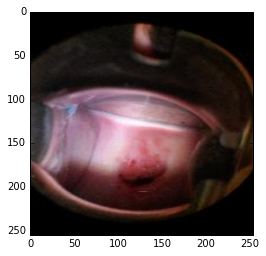

(2, 255, 255, 3)


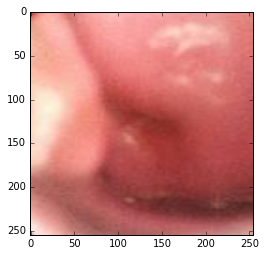

(2, 255, 255, 3)


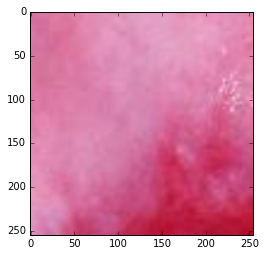

222
(2, 255, 255, 3)


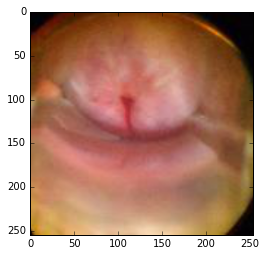

(2, 255, 255, 3)


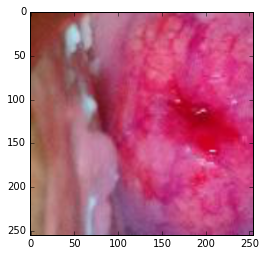

(2, 255, 255, 3)


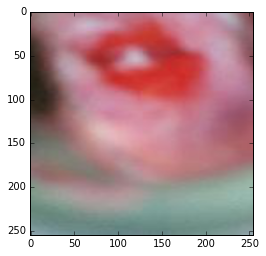

"\ng = BatchGenerator(source = 'raw')\ntrain_filepaths, train_filetargets, val_filepaths, val_filetargets = g.get_splitted_paths_from_csv(use_additional = False)\ntrain_generator = g.generate(data = train_filepaths, labels = train_filetargets, batch_size = 2, shuffle = True)\nval_generator = g.generate(data = val_filepaths, labels = val_filetargets, batch_size = 2, shuffle = True)\na = 3\nfor x,y in train_generator:  \n    a -= 1\n    plt.figure()\n    plt.imshow(x[0])\n    plt.show()\n    if a == 0:\n        break\na = 3\nfor x,y in val_generator:  \n    a -= 1\n    plt.figure()\n    plt.imshow(x[0])\n    plt.show()\n    if a == 0:\n        break\n"

In [18]:
import os
import numpy as np
import pandas as pd
import scipy.misc
import cv2
import glob  

IMAGES_FOLDER_PATH = os.path.join('..','data','images')
RAW_PATH = os.path.join(IMAGES_FOLDER_PATH,'raw')
PRE_TRAIN_PATH = os.path.join(IMAGES_FOLDER_PATH,'pre','train')


class BatchGenerator(object):
        '''
        Generate batches of data. I have decided not to keep all the images in
        memory but the image paths. Now it is reading FULL raw images and thus
        it resizes them in order to stack them and build the batches (so its slow).
        If we are going to segment images offline maybe all of them cam fit in memory.
        '''

        def __init__(self, source):
            if source == 'raw':
                self.images_source = RAW_PATH
            elif source == 'pre':
                self.images_source = PRE_TRAIN_PATH            
            return
        
        def get_splitted_paths_from_csv(self, use_additional):
            '''
            Returns the csv file and returns two lists (train and val) with
            image paths and another two with its respective the classes (0,1,2)
            '''
            #Read CSV
            validation_split_df = pd.read_csv(os.path.join(IMAGES_FOLDER_PATH,'validation_split.csv')).rename(columns = {'Type_1_1':'Type_1_extra','Type_2_1':'Type_2_extra','Type_3_1':'Type_3_extra'})
            #validation_split_df.info()
            validation_split_df = validation_split_df.applymap(lambda x: x.strip() if pd.notnull(x) else x)
            #print validation_split_df.head()
            classes = [0,1,2]
            image_folders = ['Type_1','Type_2','Type_3']

            image_folder_paths = [os.path.join(self.images_source,image_folder) for image_folder in image_folders]
            
            #Generate image paths for VALIDATION from CSV
            print 'Validation split:'
            val_filetargets, val_filepaths = [], []
            for c,image_folder in zip(classes, image_folders):
                column = list(validation_split_df[image_folder].dropna())
                val_filepaths += [os.path.join(self.images_source,image_folder,filename) for filename in column]
                val_filetargets += list(np.repeat(c,len(column)))
                #print len(column),c
                if use_additional:
                    column = list(validation_split_df[image_folder+'_extra'].dropna())
                    val_filepaths += [os.path.join(self.images_source,image_folder+'_extra',filename) for filename in column]
                    val_filetargets += list(np.repeat(c,len(column)))
                print '\t',len(column),'of type',c+1

            #Check that references in CSV exist in disk
            assert all([os.path.exists(path) for path in val_filepaths])

            #Generate image paths for TRAINING from {ALL - VALIDATION}
            print 'Training split:'
            train_filetargets, train_filepaths = [], []
            for c,image_folder in zip(classes, image_folders):
                all_folder_images = glob.glob(os.path.join(self.images_source,image_folder,'*'))
                if use_additional:
                    all_folder_images += glob.glob(os.path.join(self.images_source,image_folder+'_extra','*'))
                #Train = All - Validation
                train_folder_images = [path for path in all_folder_images if path is not val_filepaths]
                train_filepaths += train_folder_images
                train_filetargets += list(np.repeat(c,len(train_folder_images)))
                print '\t',len(train_folder_images),'of type',c+1

            #Check that unferred references in CSV exist in disk
            assert all([os.path.exists(path) for path in train_filepaths])

            '''self.train_filepaths = train_filepaths
            self.train_filetargets = train_filetargets
            self.val_filepaths = val_filepaths
            self.val_filetargets = val_filetargets'''
            return train_filepaths, train_filetargets, val_filepaths, val_filetargets
        
        def get_splitted_paths_from_segmented(self):
            '''
            Returns the segmented images and returns two lists (train and val) with
            image paths and another two with its respective the classes (0,1,2)
            '''
            return
        
        def generate(self, data, labels, batch_size=32,
                     balanced=True, shuffle=True):
            '''
            Generate batches of data images taking as input
            a list of image paths and labels
            '''
            while True:
                if shuffle:
                    data, labels = self.shuffle(data, labels)
                batches = len(data)/batch_size
                print batches
                for batch in range(batches):
                    #print batch
                    x_image_paths = data[batch*batch_size:(batch+1)*batch_size]
                    x = self.paths_to_images(x_image_paths)
                    y = np.array(labels[batch*batch_size:(batch+1)*batch_size])
                    if len(y) != batch_size:
                        break
                    print x.shape
                    yield((x, y))
                    
        def paths_to_images(self,paths):
            '''
            Converts a list of imagepaths to a list of images
            '''
            images = [scipy.misc.imread(path) for path in paths]
            #TODO remove resize when reading presegmented images
            images = [cv2.resize(img, dsize=(255,255))[np.newaxis,:,:,:] for img in images]
            #images = [img[np.newaxis,:,:,:] for img in images]
            return np.concatenate(images)
        
        def shuffle(self, data, labels):
            '''
            Shuffles data keeping <image,label> pairs
            together
            '''
            indices = np.arange(len(data))
            np.random.shuffle(indices)
            return list(pd.Series(data)[indices]), list(pd.Series(labels)[indices])

###USAGE

g = BatchGenerator(source = 'pre')
train_filepaths, train_filetargets, val_filepaths, val_filetargets = g.get_splitted_paths_from_csv(use_additional = False)
train_generator = g.generate(data = train_filepaths, labels = train_filetargets, batch_size = 32, shuffle = True)
val_generator = g.generate(data = val_filepaths, labels = val_filetargets, batch_size = 32, shuffle = True)
a = 3
for x,y in train_generator:  
    a -= 1
    print x.shape, y.shape
    '''
    plt.figure()
    plt.imshow(x[0])
    plt.show()'''
    if a == 0:
        break
a = 3
for x,y in val_generator:  
    a -= 1
    plt.figure()
    plt.imshow(x[0])
    plt.show()
    if a == 0:
        break

'''
g = BatchGenerator(source = 'raw')
train_filepaths, train_filetargets, val_filepaths, val_filetargets = g.get_splitted_paths_from_csv(use_additional = False)
train_generator = g.generate(data = train_filepaths, labels = train_filetargets, batch_size = 2, shuffle = True)
val_generator = g.generate(data = val_filepaths, labels = val_filetargets, batch_size = 2, shuffle = True)
a = 3
for x,y in train_generator:  
    a -= 1
    plt.figure()
    plt.imshow(x[0])
    plt.show()
    if a == 0:
        break
a = 3
for x,y in val_generator:  
    a -= 1
    plt.figure()
    plt.imshow(x[0])
    plt.show()
    if a == 0:
        break
'''



In [14]:
x[0].mean()

128.48365733333333

In [15]:
import scipy

In [17]:
scipy.misc.imread('/vol/tensusers/vgarciacazorla/ISMI/ISMI-Project/data/images/pre/test/3.jpg').mean()

133.0695583500395